In [1]:
import sys
import yaml
import os
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import soundfile as sf
import random
import json
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from glob import glob
import shutil
import os
from multiprocessing import Pool, cpu_count
from torch.nn.utils.rnn import pad_sequence
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
import torch.nn.utils.prune as prune
import copy
import torch.quantization
from torch.quantization import quantize_fx
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
import os
from nni.compression.pytorch.pruning import L1NormPruner
from nni.compression.pytorch.speedup import ModelSpeedup
from nni.algorithms.compression.pytorch.quantization import QAT_Quantizer
import inspect

2025-07-30 23:47:07.006996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Методы сжатия моделей

📦 1. Pruning (усечение/обрезка)
| Библиотека                          | Фреймворк    | Возможности                                                                      |
| ----------------------------------- | ------------ | -------------------------------------------------------------------------------- |
| **PyTorch**: `torch.nn.utils.prune` | PyTorch      | Встроенные методы обрезки (по L1, случайно и др.), можно применить к любому слою |
| **SparseML**                        | PyTorch / TF | Поддерживает структурное и неструктурное sparsity + экспорт                      |
| **NNCF** (OpenVINO)                 | PyTorch      | Статический и динамический pruning с совместимостью OpenVINO                     |


🔢 2. Quantization (квантование)
| Библиотека                                   | Фреймворк            | Особенности                                                 |
| -------------------------------------------- | -------------------- | ----------------------------------------------------------- |
| **TorchQuantization** / `torch.quantization` | PyTorch              | Пост-тренировочное квантование (PTQ), квантованное обучение |
| **TensorRT**                                 | TensorFlow / PyTorch | Инференс с FP16/INT8                                        |
| **ONNX Runtime**                             | ONNX                 | Поддерживает динамическое/статическое квантование           |
| **NNCF**                                     | PyTorch              | Поддерживает INT8, гибридное квантование                    |


🧠 3. Distillation (дистилляция)
| Библиотека                         | Фреймворк  | Комментарий                                |
| ---------------------------------- | ---------- | ------------------------------------------ |
| **HuggingFace `transformers`**     | PyTorch    | Есть готовая логика distilBERT и др.       |
| **Distiller** (Intel/Nervana)      | PyTorch    | Поддерживает дистилляцию + pruning + quant |
| **Knowledge Distillation Toolkit** | PyTorch/TF | Универсальный подход с teacher/student     |


🧮 4. Matrix Factorization / Low-Rank (факторизация)
| Библиотека                               | Фреймворк       | Комментарий                                |
| ---------------------------------------- | --------------- | ------------------------------------------ |
| **TorchLowRank** (или вручную через SVD) | PyTorch         | Можно вручную заменить веса на две матрицы |
| **NNCF**                                 | PyTorch         | Поддерживает low-rank compression          |
| **TensorLy**                             | NumPy / PyTorch | Поддержка CP, Tucker и SVD-разложений      |


In [2]:
df_data = pd.read_csv('data/train.csv')

In [3]:
df_data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [4]:
print(df_data["label"].value_counts())

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64


In [5]:
df_train, df_val = train_test_split(
    df_data, 
    test_size=0.2, 
    stratify=df_data["label"], 
    random_state=42
)


In [6]:
# === Датасет ===
class CassavaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.img_dir, row['image_id'])).convert('RGB')
        label = row['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# === Конфигурация ===

IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 5

In [8]:
# === Аугментации и нормализация ===

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [9]:
# === DataLoader-ы ===
train_dataset = CassavaDataset(df_train, "data/train_images", transform=transform)
val_dataset = CassavaDataset(df_val, "data/train_images", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [10]:
# === Переутяжелённая CNN ===
class HeavyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            *[self._block(in_ch, out_ch) for in_ch, out_ch in zip(
                [3, 64, 128, 256, 512, 512], [64, 128, 256, 512, 512, 1024])]
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, NUM_CLASSES)
        )

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [11]:
# === Обучение ===
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

# === Валидация ===
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return running_loss / len(loader.dataset), correct / len(loader.dataset), all_preds, all_labels

In [12]:
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Обучение:   7%|████████████████▋                                                                                                                                                                                                                                         | 1/15 [08:13<1:55:08, 493.43s/it]

Epoch 1/15 | Train Acc: 0.6496 | Val Acc: 0.6914


Обучение:  13%|█████████████████████████████████▎                                                                                                                                                                                                                        | 2/15 [15:55<1:42:57, 475.17s/it]

Epoch 2/15 | Train Acc: 0.7133 | Val Acc: 0.6178


Обучение:  20%|██████████████████████████████████████████████████                                                                                                                                                                                                        | 3/15 [23:38<1:33:53, 469.49s/it]

Epoch 3/15 | Train Acc: 0.7490 | Val Acc: 0.7519


Обучение:  27%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 4/15 [31:20<1:25:33, 466.69s/it]

Epoch 4/15 | Train Acc: 0.7807 | Val Acc: 0.7857


Обучение:  33%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 5/15 [39:03<1:17:30, 465.08s/it]

Epoch 5/15 | Train Acc: 0.8000 | Val Acc: 0.7493


Обучение:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 6/15 [46:44<1:09:35, 463.94s/it]

Epoch 6/15 | Train Acc: 0.8168 | Val Acc: 0.7666


Обучение:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 7/15 [54:25<1:01:43, 462.98s/it]

Epoch 7/15 | Train Acc: 0.8316 | Val Acc: 0.7958


Обучение:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8/15 [1:02:07<53:58, 462.62s/it]

Epoch 8/15 | Train Acc: 0.8479 | Val Acc: 0.8175


Обучение:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9/15 [1:09:48<46:11, 461.90s/it]

Epoch 9/15 | Train Acc: 0.8622 | Val Acc: 0.8133


Обучение:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10/15 [1:17:28<38:26, 461.30s/it]

Epoch 10/15 | Train Acc: 0.8785 | Val Acc: 0.7554


Обучение:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 11/15 [1:25:08<30:44, 461.19s/it]

Epoch 11/15 | Train Acc: 0.8960 | Val Acc: 0.7624


Обучение:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 12/15 [1:32:50<23:03, 461.17s/it]

Epoch 12/15 | Train Acc: 0.9090 | Val Acc: 0.7673


Обучение:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 13/15 [1:40:31<15:22, 461.31s/it]

Epoch 13/15 | Train Acc: 0.9253 | Val Acc: 0.7979


Обучение:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 14/15 [1:48:12<07:41, 461.29s/it]

Epoch 14/15 | Train Acc: 0.9381 | Val Acc: 0.7678


Обучение: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:55:53<00:00, 463.59s/it]

Epoch 15/15 | Train Acc: 0.9509 | Val Acc: 0.7724


              precision    recall  f1-score   support

           0       0.41      0.47      0.44       217
           1       0.76      0.58      0.65       438
           2       0.47      0.79      0.59       477
           3       0.95      0.87      0.91      2632
           4       0.59      0.55      0.57       516

    accuracy                           0.77      4280
   macro avg       0.64      0.65      0.63      4280
weighted avg       0.80      0.77      0.78      4280



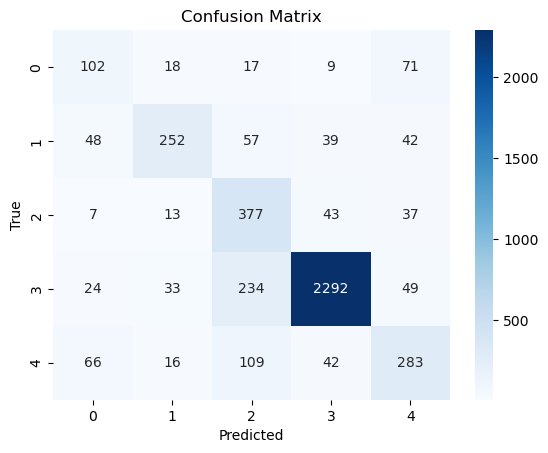

In [14]:
# === Основной цикл ===
model = HeavyCNN().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in tqdm(range(EPOCHS), desc="Обучение"):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# === Финальная оценка ===
_, _, y_pred, y_true = evaluate(model, val_loader, criterion)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [17]:
# torch.save(model.state_dict(), "model_full.pth")

In [ ]:
# Восстановить позже
model.load_state_dict(torch.load("model_full.pth"))

In [18]:
model_base = copy.deepcopy(model)

In [13]:
# Пример обрезки Conv2d и Linear слоёв
def apply_pruning(model, amount=0.3):  # 30% обрезки
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            print(f"Pruning {name} ({type(module).__name__})")
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

In [19]:
apply_pruning(model, amount=0.3)

Pruning features.0.0 (Conv2d)
Pruning features.0.3 (Conv2d)
Pruning features.1.0 (Conv2d)
Pruning features.1.3 (Conv2d)
Pruning features.2.0 (Conv2d)
Pruning features.2.3 (Conv2d)
Pruning features.3.0 (Conv2d)
Pruning features.3.3 (Conv2d)
Pruning features.4.0 (Conv2d)
Pruning features.4.3 (Conv2d)
Pruning features.5.0 (Conv2d)
Pruning features.5.3 (Conv2d)
Pruning classifier.1 (Linear)
Pruning classifier.3 (Linear)


HeavyCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [21]:
torch.save(model.state_dict(), "model_after_prune.pth")

# Попробуем без переобучения

              precision    recall  f1-score   support

           0       0.56      0.17      0.26       217
           1       0.80      0.21      0.34       438
           2       0.39      0.60      0.48       477
           3       0.95      0.74      0.83      2632
           4       0.34      0.87      0.49       516

    accuracy                           0.66      4280
   macro avg       0.61      0.52      0.48      4280
weighted avg       0.78      0.66      0.67      4280



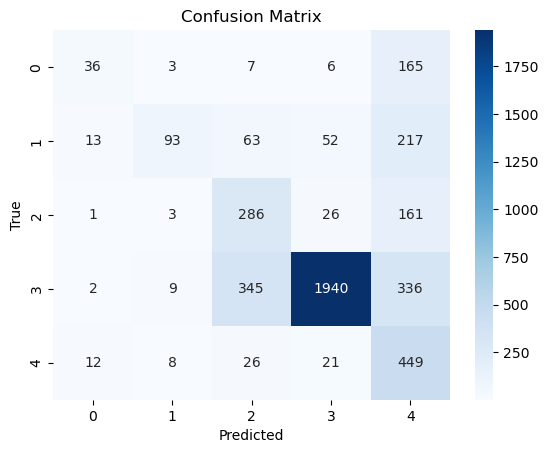

In [20]:
_, _, y_pred, y_true = evaluate(model, val_loader, criterion)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

| Метрика         | До обрезки | После обрезки | Изменение |
| --------------- | ---------- | ------------- | --------- |
| **Accuracy**    | 0.79       | 0.66          | 🔻 -13%   |
| **Macro F1**    | 0.62       | 0.48          | 🔻 -14%   |
| **Weighted F1** | 0.78       | 0.67          | 🔻 -11%   |


# Попробуем переобучить модель(после обрезки)

In [14]:
EPOCHS = 5
model = HeavyCNN().to(DEVICE)
model.load_state_dict(torch.load("model_full.pth"))
apply_pruning(model, amount=0.3)

/tmp/ipykernel_32483/899776885.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_full.pth"))


Pruning features.0.0 (Conv2d)
Pruning features.0.3 (Conv2d)
Pruning features.1.0 (Conv2d)
Pruning features.1.3 (Conv2d)
Pruning features.2.0 (Conv2d)
Pruning features.2.3 (Conv2d)
Pruning features.3.0 (Conv2d)
Pruning features.3.3 (Conv2d)
Pruning features.4.0 (Conv2d)
Pruning features.4.3 (Conv2d)
Pruning features.5.0 (Conv2d)
Pruning features.5.3 (Conv2d)
Pruning classifier.1 (Linear)
Pruning classifier.3 (Linear)


HeavyCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

Обучение:  20%|██████████████████████████████████████████████████▌                                                                                                                                                                                                          | 1/5 [09:34<38:17, 574.45s/it]

Epoch 1/5 | Train Acc: 0.9652 | Val Acc: 0.8086


Обучение:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 2/5 [19:58<30:11, 603.73s/it]

Epoch 2/5 | Train Acc: 0.9830 | Val Acc: 0.8061


Обучение:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 3/5 [29:59<20:04, 602.24s/it]

Epoch 3/5 | Train Acc: 0.9891 | Val Acc: 0.8114


Обучение:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4/5 [40:24<10:11, 611.36s/it]

Epoch 4/5 | Train Acc: 0.9937 | Val Acc: 0.8086


Обучение: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [50:14<00:00, 602.86s/it]

Epoch 5/5 | Train Acc: 0.9965 | Val Acc: 0.8077


              precision    recall  f1-score   support

           0       0.51      0.41      0.45       217
           1       0.70      0.63      0.66       438
           2       0.71      0.57      0.64       477
           3       0.91      0.94      0.93      2632
           4       0.56      0.66      0.61       516

    accuracy                           0.81      4280
   macro avg       0.68      0.64      0.66      4280
weighted avg       0.80      0.81      0.80      4280



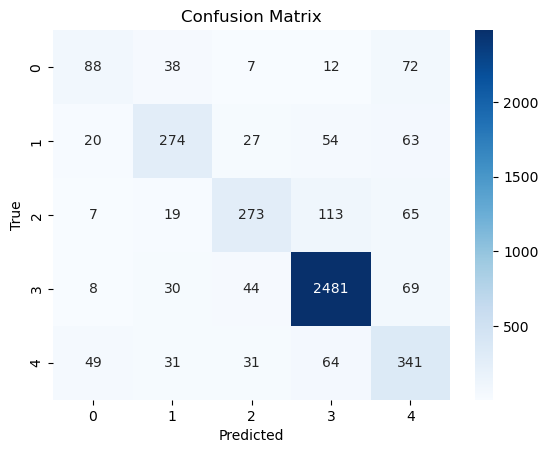

In [15]:
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

for epoch in tqdm(range(EPOCHS), desc="Обучение"):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# === Финальная оценка ===
_, _, y_pred, y_true = evaluate(model, val_loader, criterion)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# После обрезки точность поулчалась даже выше, хотя как раз на размре это никак е  сказалось как и на времени работы.

In [16]:
# Удалить маску и weight_orig, оставить только обрезанные веса
for module in model.modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        prune.remove(module, 'weight')

In [17]:
torch.save(model.state_dict(), "model_pruned_cleaned.pth")


In [16]:
model = HeavyCNN()
model.load_state_dict(torch.load("model_full.pth", map_location="cpu"))
model.eval()

# 2. Настройка qconfig
qconfig = get_default_qconfig("fbgemm")  # "qnnpack" — для ARM
qconfig_dict = {"": qconfig}

# 3. Пример входа для FX (важно!)
example_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)

# 4. Подготовка модели для квантования (prepare_fx)
prepared_model = prepare_fx(model, qconfig_dict, example_input)

# 5. Калибровка на реальных данных
with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        prepared_model(images)
        if i >= 10:  # калибруем на 10 батчах
            break

# 6. Квантование (convert_fx)
quantized_model = convert_fx(prepared_model)

# 7. Сохранение квантованной модели
torch.save(quantized_model.state_dict(), "model_quantized.pth")

# 8. Проверка размера файла

print("Размер квантованной модели:", os.path.getsize("model_quantized.pth") / 1024 / 1024, "MB")



/tmp/ipykernel_34014/3838583043.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_full.pth", map_location="cpu"))
/home/saatarko/an

Размер квантованной модели: 23.100080490112305 MB


In [17]:
torch.save(quantized_model.state_dict(), "quantized_model.pth")

              precision    recall  f1-score   support

           0       0.45      0.46      0.46       217
           1       0.85      0.39      0.53       438
           2       0.67      0.57      0.62       477
           3       0.91      0.93      0.92      2632
           4       0.49      0.75      0.60       516

    accuracy                           0.79      4280
   macro avg       0.68      0.62      0.62      4280
weighted avg       0.80      0.79      0.78      4280



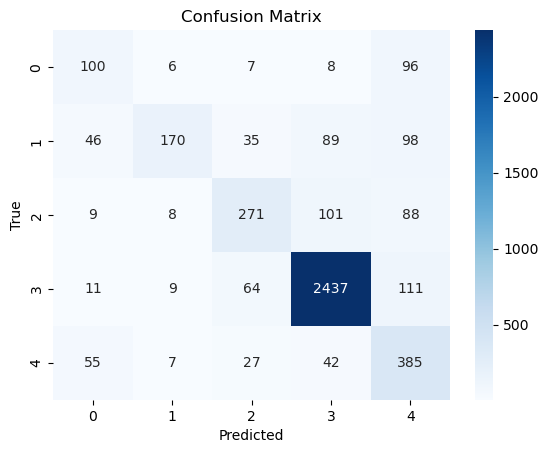

In [20]:
criterion = nn.CrossEntropyLoss()
DEVICE = torch.device("cpu")

_, _, y_pred, y_true = evaluate(quantized_model, val_loader, criterion)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

| Класс | Precision   | Recall      | F1          | Support |
| ----- | ----------- | ----------- | ----------- | ------- |
| **0** | 0.47 → 0.45 | 0.46 → 0.46 | 0.46 → 0.46 | 217     |
| **1** | 0.87 → 0.85 | 0.38 → 0.39 | 0.53 → 0.53 | 438     |
| **2** | 0.68 → 0.67 | 0.56 → 0.57 | 0.61 → 0.62 | 477     |
| **3** | 0.91 → 0.91 | 0.93 → 0.93 | 0.92 → 0.92 | 2632    |
| **4** | 0.49 → 0.49 | 0.76 → 0.75 | 0.60 → 0.60 | 516     |



Точность абсолютно не пострадала.

Разница по метрикам — в пределах статистического шума (±0.01).

Это значит, что квантование прошло идеально — модель стала меньше, но не потеряла в качестве.



# Факторизация

In [13]:
def svd_factorize_conv_layer(conv_layer, rank_ratio=0.5):
    """
    Разложение Conv2d слоя через SVD с обрезкой ранга.

    Args:
      conv_layer (nn.Conv2d): исходный свёрточный слой (предполагаем kernel_size=3).
      rank_ratio (float): доля сохранённой энергии (сингулярных значений), например 0.5 = 50%.

    Returns:
      nn.Sequential из двух слоёв Conv2d (3x3 и 1x1)
    """
    W = conv_layer.weight.data  # (out_channels, in_channels, kH, kW)
    out_channels, in_channels, kH, kW = W.shape
    assert kH == 3 and kW == 3, "Текущая реализация для ядра 3x3"

    W_mat = W.view(out_channels, -1)  # (out_channels, in_channels * kH * kW)

    # SVD
    U, S, Vh = torch.linalg.svd(W_mat, full_matrices=False)

    # Определяем ранг, сохраняющий rank_ratio энергии
    energy = torch.cumsum(S**2, dim=0) / torch.sum(S**2)
    rank = (energy < rank_ratio).sum().item() + 1

    U_r = U[:, :rank]
    S_r = S[:rank]
    Vh_r = Vh[:rank, :]

    # Первый слой: (rank, in_channels, 3, 3)
    first_conv = nn.Conv2d(in_channels, rank, kernel_size=3, padding=1, bias=False)
    first_conv.weight.data = Vh_r.view(rank, in_channels, 3, 3).contiguous()

    # Второй слой: (out_channels, rank, 1, 1)
    second_conv = nn.Conv2d(rank, out_channels, kernel_size=1, bias=True)
    second_conv.weight.data = (U_r @ torch.diag(S_r)).view(out_channels, rank, 1, 1).contiguous()
    # Инициализация bias второго слоя (копируем из оригинала, если есть)
    if conv_layer.bias is not None:
        second_conv.bias.data = conv_layer.bias.data.clone()
    else:
        second_conv.bias.data.zero_()

    return nn.Sequential(first_conv, second_conv)


def factorize_model_svd(model, rank_ratio=0.5):
    """
    Проходит по модели, заменяя каждый Conv2d 3x3 на факторизованный вариант.

    Args:
      model (nn.Module): исходная модель.
      rank_ratio (float): доля энергии для ранга.

    Returns:
      model с заменёнными слоями.
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d) and module.kernel_size == (3, 3):
            print(f"Факторизация слоя: {name} (Conv2d {module.in_channels}→{module.out_channels})")
            setattr(model, name, svd_factorize_conv_layer(module, rank_ratio))
        else:
            factorize_model_svd(module, rank_ratio)
    return model

In [14]:
model = HeavyCNN()
model.load_state_dict(torch.load("model_full.pth", map_location="cpu"))
model.eval()

# Факторизуем (оставляем, например, 50% энергии)
model_fact = factorize_model_svd(model, rank_ratio=0.5)

# Можно проверить размер модели
torch.save(model_fact.state_dict(), "model_factorized.pth")
print("Размер после факторизации:", os.path.getsize("model_factorized.pth") / 1024 / 1024, "MB")


/tmp/ipykernel_41432/751327827.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_full.pth", map_location="cpu"))


Факторизация слоя: 0 (Conv2d 3→64)
Факторизация слоя: 3 (Conv2d 64→64)
Факторизация слоя: 0 (Conv2d 64→128)
Факторизация слоя: 3 (Conv2d 128→128)
Факторизация слоя: 0 (Conv2d 128→256)
Факторизация слоя: 3 (Conv2d 256→256)
Факторизация слоя: 0 (Conv2d 256→512)
Факторизация слоя: 3 (Conv2d 512→512)
Факторизация слоя: 0 (Conv2d 512→512)
Факторизация слоя: 3 (Conv2d 512→512)
Факторизация слоя: 0 (Conv2d 512→1024)
Факторизация слоя: 3 (Conv2d 1024→1024)
Размер после факторизации: 10.192522048950195 MB


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.10      0.84      0.18       438
           2       0.00      0.00      0.00       477
           3       0.00      0.00      0.00      2632
           4       0.21      0.22      0.21       516

    accuracy                           0.11      4280
   macro avg       0.06      0.21      0.08      4280
weighted avg       0.03      0.11      0.04      4280



/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

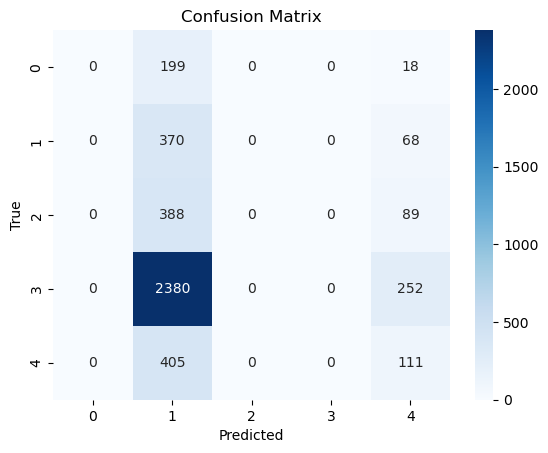

In [24]:
criterion = nn.CrossEntropyLoss()
DEVICE = torch.device("cpu")

_, _, y_pred, y_true = evaluate(model_fact, val_loader, criterion)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Без переобучения получилась полная фигня

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fact.to(device)

optimizer = torch.optim.Adam(model_fact.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model_fact.train()
for epoch in tqdm(range(5),desc="Обучение"):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_fact(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Обучение:  20%|██████████████████████████████████████████████████▌                                                                                                                                                                                                          | 1/5 [06:58<27:54, 418.68s/it]

Epoch 1, Loss: 0.5082


Обучение:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 2/5 [13:30<20:08, 402.76s/it]

Epoch 2, Loss: 0.3457


Обучение:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 3/5 [20:04<13:17, 398.83s/it]

Epoch 3, Loss: 0.2738


Обучение:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4/5 [26:39<06:37, 397.15s/it]

Epoch 4, Loss: 0.2131


Обучение: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [33:17<00:00, 399.44s/it]

Epoch 5, Loss: 0.1663


              precision    recall  f1-score   support

           0       0.50      0.50      0.50       217
           1       0.69      0.62      0.66       438
           2       0.75      0.49      0.59       477
           3       0.86      0.97      0.91      2632
           4       0.62      0.49      0.55       516

    accuracy                           0.80      4280
   macro avg       0.69      0.61      0.64      4280
weighted avg       0.78      0.80      0.78      4280



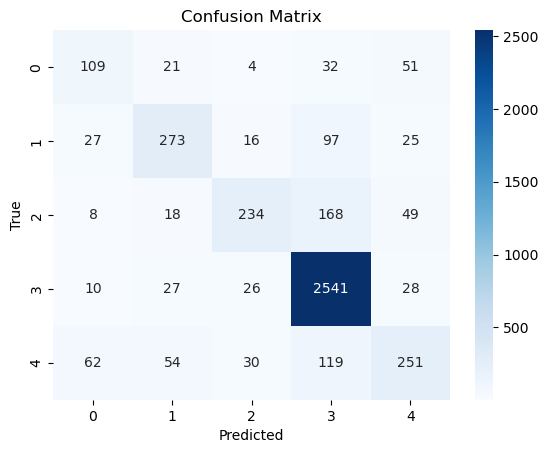

In [16]:
_, _, y_pred, y_true = evaluate(model_fact, val_loader, criterion)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Дистилляция

In [15]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # [B, 16, H, W]
            nn.ReLU(),
            nn.MaxPool2d(2),                            # [B, 16, H/2, W/2]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),# [B, 32, H/2, W/2]
            nn.ReLU(),
            nn.MaxPool2d(2),                            # [B, 32, H/4, W/4]
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),                    # [B, 32, 1, 1]
            nn.Flatten(),                               # [B, 32]
            nn.Linear(32, num_classes)                  # [B, NUM_CLASSES]
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [16]:
def distillation_loss(student_logits, teacher_logits, T=4.0):
    """
    student_logits, teacher_logits — до softmax
    """
    # Приводим к распределениям вероятностей с температурой
    student_soft = F.log_softmax(student_logits / T, dim=1)
    teacher_soft = F.softmax(teacher_logits / T, dim=1)

    loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (T * T)
    return loss



In [17]:
def train_student(student, teacher, dataloader, optimizer, device, epochs=10, T=2.0, alpha=0.7):
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            with torch.no_grad():
                teacher_logits = teacher(x)

            student_logits = student(x)
            loss = distillation_loss(student_logits, teacher_logits, y, T, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher_model = HeavyCNN()
teacher_model.load_state_dict(torch.load("model_full.pth"))
teacher_model.eval()
teacher_model.to(device)

student_model = TinyCNN(num_classes=5).to(device)

/tmp/ipykernel_11184/4241743433.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("model_full.pth"))


In [19]:
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
epochs = 80
T = 4.0

for epoch in range(epochs):
    student_model.train()
    total_loss = 0

    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)

        with torch.no_grad():
            teacher_logits = teacher_model(images)

        student_logits = student_model(images)
        loss = distillation_loss(student_logits, teacher_logits, T)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Distill Loss: {total_loss / len(train_loader):.4f}")

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 1] Distill Loss: 6.3317


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 2] Distill Loss: 5.8779


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:05<00:00,  2.18it/s]


[Epoch 3] Distill Loss: 5.3984


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 4] Distill Loss: 5.0317


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 5] Distill Loss: 4.8528


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


[Epoch 6] Distill Loss: 4.7074


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]


[Epoch 7] Distill Loss: 4.6156


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]


[Epoch 8] Distill Loss: 4.5670


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]


[Epoch 9] Distill Loss: 4.5155


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 10] Distill Loss: 4.4630


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 11] Distill Loss: 4.4047


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 12] Distill Loss: 4.3987


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 13] Distill Loss: 4.3378


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 14] Distill Loss: 4.2865


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 15] Distill Loss: 4.2473


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 16] Distill Loss: 4.1877


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


[Epoch 17] Distill Loss: 4.1739


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 18] Distill Loss: 4.1298


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 19] Distill Loss: 4.0900


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]


[Epoch 20] Distill Loss: 4.0562


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 21] Distill Loss: 4.0213


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 22] Distill Loss: 3.9832


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 23] Distill Loss: 3.9443


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 24] Distill Loss: 3.9138


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 25] Distill Loss: 3.8873


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 26] Distill Loss: 3.8624


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 27] Distill Loss: 3.8351


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 28] Distill Loss: 3.8141


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 29] Distill Loss: 3.7993


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 30] Distill Loss: 3.7711


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 31] Distill Loss: 3.7464


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 32] Distill Loss: 3.7447


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 33] Distill Loss: 3.7361


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 34] Distill Loss: 3.7151


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 35] Distill Loss: 3.6739


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


[Epoch 36] Distill Loss: 3.6885


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 37] Distill Loss: 3.6711


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 38] Distill Loss: 3.6413


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 39] Distill Loss: 3.6473


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


[Epoch 40] Distill Loss: 3.6303


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 41] Distill Loss: 3.6064


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 42] Distill Loss: 3.5916


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 43] Distill Loss: 3.5958


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


[Epoch 44] Distill Loss: 3.5679


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:05<00:00,  2.18it/s]


[Epoch 45] Distill Loss: 3.5418


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:05<00:00,  2.18it/s]


[Epoch 46] Distill Loss: 3.5361


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:05<00:00,  2.18it/s]


[Epoch 47] Distill Loss: 3.5213


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:05<00:00,  2.18it/s]


[Epoch 48] Distill Loss: 3.5222


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:05<00:00,  2.18it/s]


[Epoch 49] Distill Loss: 3.4940


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:05<00:00,  2.18it/s]


[Epoch 50] Distill Loss: 3.4743


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 51] Distill Loss: 3.4507


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 52] Distill Loss: 3.4602


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 53] Distill Loss: 3.4415


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 54] Distill Loss: 3.4432


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.18it/s]


[Epoch 55] Distill Loss: 3.4185


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.18it/s]


[Epoch 56] Distill Loss: 3.3965


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.18it/s]


[Epoch 57] Distill Loss: 3.3973


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 58] Distill Loss: 3.3864


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 59] Distill Loss: 3.3721


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 60] Distill Loss: 3.3511


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 61] Distill Loss: 3.3684


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 62] Distill Loss: 3.3558


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 63] Distill Loss: 3.3231


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 64] Distill Loss: 3.3467


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 65] Distill Loss: 3.3250


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 66] Distill Loss: 3.3271


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


[Epoch 67] Distill Loss: 3.3232


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 68] Distill Loss: 3.3003


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.18it/s]


[Epoch 69] Distill Loss: 3.2954


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 70] Distill Loss: 3.2778


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


[Epoch 71] Distill Loss: 3.2679


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.19it/s]


[Epoch 72] Distill Loss: 3.2650


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]


[Epoch 73] Distill Loss: 3.2600


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:28<00:00,  1.99it/s]


[Epoch 74] Distill Loss: 3.2551


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:04<00:00,  2.18it/s]


[Epoch 75] Distill Loss: 3.2539


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:02<00:00,  2.20it/s]


[Epoch 76] Distill Loss: 3.2361


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:02<00:00,  2.20it/s]


[Epoch 77] Distill Loss: 3.2233


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]


[Epoch 78] Distill Loss: 3.2405


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]


[Epoch 79] Distill Loss: 3.2180


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.20it/s]

[Epoch 80] Distill Loss: 3.2099


In [20]:
torch.save(student_model.state_dict(), "student_model.pth")

              precision    recall  f1-score   support

           0       0.32      0.13      0.19       217
           1       0.73      0.05      0.10       438
           2       0.56      0.21      0.31       477
           3       0.75      0.98      0.85      2632
           4       0.40      0.42      0.41       516

    accuracy                           0.69      4280
   macro avg       0.55      0.36      0.37      4280
weighted avg       0.66      0.69      0.63      4280



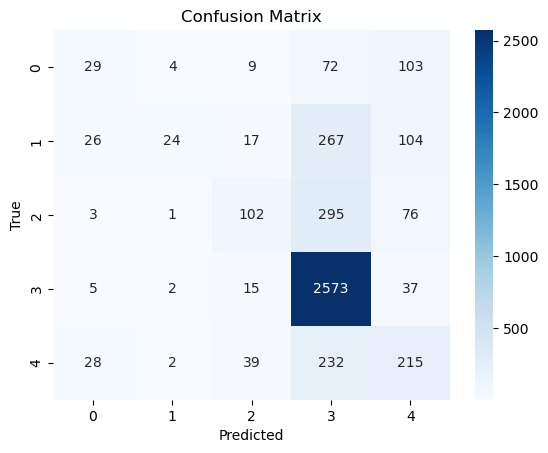

In [21]:
student_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        logits = student_model(images)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Фреймфорки

| Фреймворк                        | Поддержка           | Методы                                   | Комментарий                |
| -------------------------------- | ------------------- | ---------------------------------------- | -------------------------- |
| 🤖 **NNI (by Microsoft)**        | PyTorch, TensorFlow | Pruning, Quantization, Distillation, NAS | Очень гибкий и мощный      |
| 🧰 **Optimum (HuggingFace)**     | Только Transformer  | Pruning, Quantization                    | Лучше для NLP              |
| 🧪 **SparseML (by NeuralMagic)** | PyTorch, ONNX       | Pruning, Quantization, Distillation      | Оптимизация под inference  |
| 🔬 **Intel Neural Compressor**   | PyTorch, TensorFlow | Quantization, Pruning                    | Часто используется в проде |
| 🔧 **TorchDistiller (Facebook)** | PyTorch             | Mostly Distillation                      | Старее, но рабочий         |
